In [2]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
end_epoch = 20

In [4]:
device

'cuda'

In [5]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [6]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [160]:
import matplotlib.pyplot as plt
import numpy as np

In [231]:
class_count = {i: 0 for i in range(10)}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

IndexError: index 5 is out of bounds for axis 1 with size 5

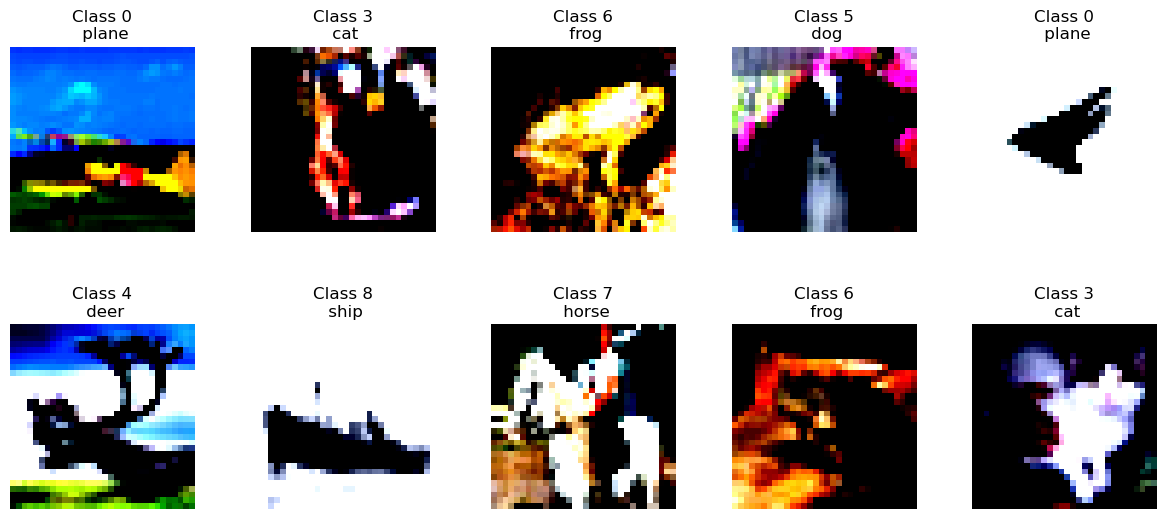

In [239]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5)
for i in range(10):
    for j in range(2):

        x = torch.randint(0,100,(1,))
        image, label = testset[x]

        # Plot the image in the corresponding subplot
        axs[j,i].imshow(image.permute(1,2,0))
        axs[j,i].set_title(f"Class {label}\n {classes[label]}")
        axs[j,i].axis('off')

plt.show()


# # Save the image
# save_dir = './saved_images'
# os.makedirs(save_dir, exist_ok=True)
# if class_count[label] < 2:
#     # Ensure the image tensor has three color channels (RGB)
#     if image.shape[0] == 1:
#         # If the image has a single channel, duplicate it to create three channels
#         image = torch.cat([image] * 3, dim=0)

#     # Convert tensor to NumPy array
#     image_np = image.numpy().transpose((1, 2, 0))

#     # De-normalize the image (if normalization was applied)
#     image_np = image_np * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])

#     # Save the image
#     image_filename = f'{classes[label]}_{class_count[label]}.png'
#     image_path = os.path.join(save_dir, image_filename)
#     torchvision.utils.save_image(image, image_path)
#     # Increment the count for the current class
#     class_count[label] += 1

#     # Print the saved image path
#     print(f"Image saved at: {image_path}")
# else:
#     print(f"Already saved 2 samples for class {label}.")

class_count

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


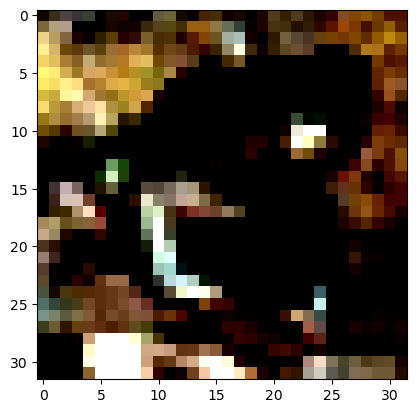

In [141]:
x = torch.randint(0,100,(1,))
plt.imshow(testset[x][0].permute(1,2,0))

In [243]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        "M",
        512,
        512,
        "M",
        512,
        512,
        "M",
    ],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}

In [241]:
class VGG(nn.Module):
    def __init__(
        self,
        architecture,
        in_channels=3,
        in_height=224,
        in_width=224,
        num_hidden=4096,
        num_classes=10
    ):
        super(VGG, self).__init__()
        self.in_channels = in_channels
        self.in_width = in_width
        self.in_height = in_height
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.convs = self.init_convs(architecture)
        self.fcs = self.init_fcs(architecture)

    def forward(self, x):
        x = self.convs(x)
        x = x.reshape(x.size(0), -1)
        x = self.fcs(x)
        return x

    def init_fcs(self, architecture):
        pool_count = architecture.count("M")
        factor = (2 ** pool_count)
        if (self.in_height % factor) + (self.in_width % factor) != 0:
            raise ValueError(
                f"`in_height` and `in_width` must be multiples of {factor}"
            )
        out_height = self.in_height // factor
        out_width = self.in_width // factor
        last_out_channels = next(
            x for x in architecture[::-1] if type(x) == int
        )
        return nn.Sequential(
            nn.Linear(
                last_out_channels * out_height * out_width,
                self.num_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(self.num_hidden, self.num_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(self.num_hidden, self.num_classes),
            nn.ReLU()
        )

    def init_convs(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers.extend(
                    [
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding=(1, 1),
                        ),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                    ]
                )
                in_channels = x
            else:
                layers.append(
                    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
                )

        return nn.Sequential(*layers)

In [10]:
VGG19 = VGG(
    in_channels=3,
    in_height=32,
    in_width=32,
    architecture=VGG_types["VGG19"]
)

In [11]:
print(VGG19)

VGG(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1

In [12]:
# standard_input = torch.randn((2, 3, 224, 224))


In [13]:
# y = VGG19(standard_input)
# y.shape, y


In [14]:
# y.detach()

In [15]:
VGG19 = VGG19.to(device)

if device == 'cuda':
    VGG19 = torch.nn.DataParallel(VGG19)
    cudnn.benchmark = True

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG19.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=end_epoch)

In [17]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    VGG19.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = VGG19(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 39 ==0: print(f"Epoch: {epoch}  Batch: {batch_idx} \n Train Loss:{(train_loss/(batch_idx+1)):.3f} \n  Train Accuracy:{(100*(correct/total)):.3f}")
    print(f"\n\n Epoch: {epoch}  ------->> Train Loss:{(train_loss/(batch_idx+1)):.3f} \n  ------->> Train Accuracy:{(100*(correct/total)):.3f} \n\n")




In [18]:
def test(epoch):
    global best_acc
    VGG19.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = VGG19(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 20 ==0: print(f"Epoch: {epoch}  Batch: {batch_idx} \n Test Loss:{(test_loss/(batch_idx+1)):.3f} \n Test Accuracy:{(100*(correct/total)):.3f}")
    print(f"\n\n Epoch: {epoch}  ------->> Test Loss:{(test_loss/(batch_idx+1)):.3f} \n  ------->> Test Accuracy:{(100*(correct/total)):.3f} \n\n")

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..\n')
        state = {
            'model_state_dict': VGG19.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [19]:
for epoch in range(start_epoch, end_epoch):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
Epoch: 0  Batch: 0 
 Train Loss:2.332 
  Train Accuracy:5.469
Epoch: 0  Batch: 39 
 Train Loss:2.268 
  Train Accuracy:14.277
Epoch: 0  Batch: 78 
 Train Loss:2.246 
  Train Accuracy:15.704
Epoch: 0  Batch: 117 
 Train Loss:2.219 
  Train Accuracy:16.519
Epoch: 0  Batch: 156 
 Train Loss:2.198 
  Train Accuracy:17.252
Epoch: 0  Batch: 195 
 Train Loss:2.183 
  Train Accuracy:17.670
Epoch: 0  Batch: 234 
 Train Loss:2.172 
  Train Accuracy:17.989
Epoch: 0  Batch: 273 
 Train Loss:2.160 
  Train Accuracy:18.451
Epoch: 0  Batch: 312 
 Train Loss:2.141 
  Train Accuracy:18.902
Epoch: 0  Batch: 351 
 Train Loss:2.121 
  Train Accuracy:19.502
Epoch: 0  Batch: 390 
 Train Loss:2.100 
  Train Accuracy:20.318


 Epoch: 0  ------->> Train Loss:2.100 
  ------->> Train Accuracy:20.318 


Epoch: 0  Batch: 0 
 Test Loss:1.914 
 Test Accuracy:27.000
Epoch: 0  Batch: 20 
 Test Loss:1.897 
 Test Accuracy:24.762
Epoch: 0  Batch: 40 
 Test Loss:1.907 
 Test Accuracy:24.463
Epoch: 0  Batch: 60 



 Epoch: 6  ------->> Test Loss:0.603 
  ------->> Test Accuracy:79.380 


Saving..


Epoch: 7
Epoch: 7  Batch: 0 
 Train Loss:0.585 
  Train Accuracy:80.469
Epoch: 7  Batch: 39 
 Train Loss:0.502 
  Train Accuracy:83.320
Epoch: 7  Batch: 78 
 Train Loss:0.513 
  Train Accuracy:83.277
Epoch: 7  Batch: 117 
 Train Loss:0.500 
  Train Accuracy:83.587
Epoch: 7  Batch: 156 
 Train Loss:0.503 
  Train Accuracy:83.430
Epoch: 7  Batch: 195 
 Train Loss:0.497 
  Train Accuracy:83.665
Epoch: 7  Batch: 234 
 Train Loss:0.498 
  Train Accuracy:83.647
Epoch: 7  Batch: 273 
 Train Loss:0.497 
  Train Accuracy:83.611
Epoch: 7  Batch: 312 
 Train Loss:0.500 
  Train Accuracy:83.469
Epoch: 7  Batch: 351 
 Train Loss:0.498 
  Train Accuracy:83.494
Epoch: 7  Batch: 390 
 Train Loss:0.497 
  Train Accuracy:83.578


 Epoch: 7  ------->> Train Loss:0.497 
  ------->> Train Accuracy:83.578 


Epoch: 7  Batch: 0 
 Test Loss:0.516 
 Test Accuracy:83.000
Epoch: 7  Batch: 20 
 Test Loss:0.526 
 Test Accuracy:8

KeyboardInterrupt: 

In [248]:
from torchvision import transforms
from PIL import Image

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# VGG19 model instantiated
model = VGG(
    in_channels=3,
    in_height=32,
    in_width=32,
    architecture=VGG_types["VGG19"]
)

# Load the saved model state dict
checkpoint_path = "checkpoint/ckpt.pth"
checkpoint = torch.load(checkpoint_path)

# Check if the model was saved using DataParallel
if 'module.' in list(checkpoint['model_state_dict'].keys())[0]:
    # Remove the 'module.' prefix from the keys
    state_dict = {key.replace('module.', ''): value for key, value in checkpoint['model_state_dict'].items()}
else:
    state_dict = checkpoint['model_state_dict']

# Load the model state_dict
model.load_state_dict(state_dict)

# Load other checkpoint information
best_acc = checkpoint['acc']
epoch = checkpoint['epoch']
model.eval()

def inference(path_to_image):
    # Define image transformations
    transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

    # Load and preprocess the image
    image = Image.open(path_to_image).convert('RGB')
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Optionally, apply softmax if your model outputs raw logits
    probabilities = nn.functional.softmax(output[0], dim=0)

    # Get the predicted class index
    predicted_class = torch.argmax(probabilities).item()

    return predicted_class, probabilities[predicted_class].item()

In [251]:
path_to_image = "saved_images/plane_0.png"
predicted_class, confidence = inference(path_to_image)

print(f"Predicted Class: {predicted_class}")
print(f"Class Label: {classes[predicted_class]}")
print(f"Confidence: {confidence}")

Predicted Class: 0
Class Label: plane
Confidence: 0.9509385228157043


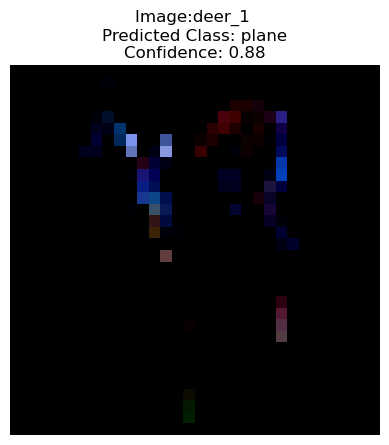

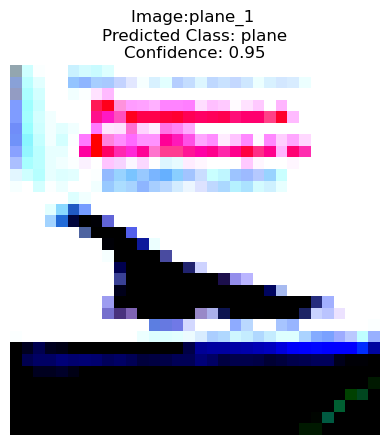

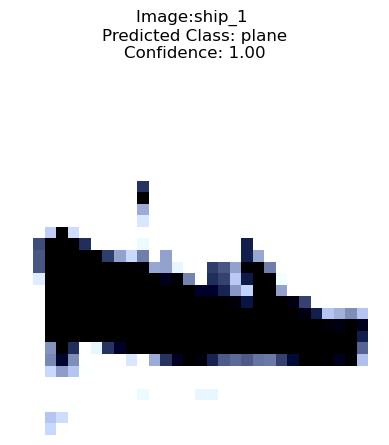

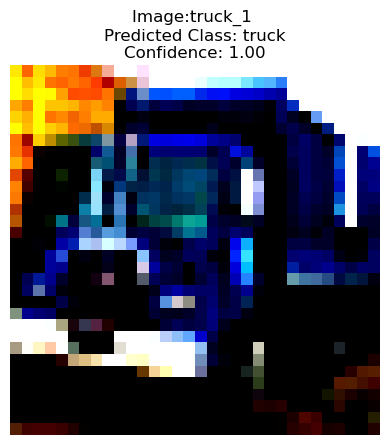

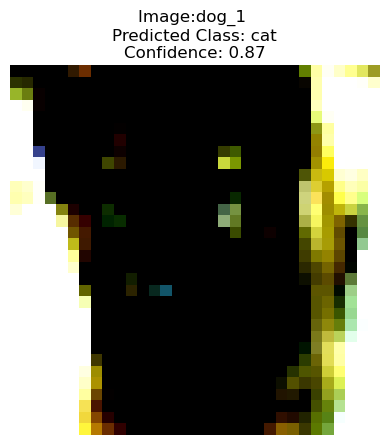

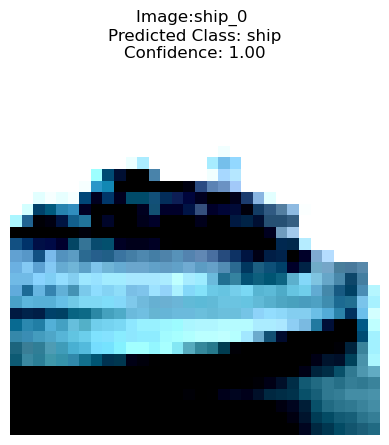

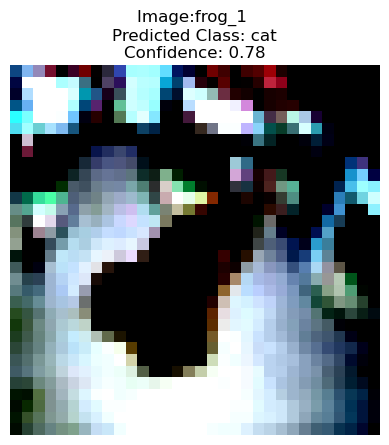

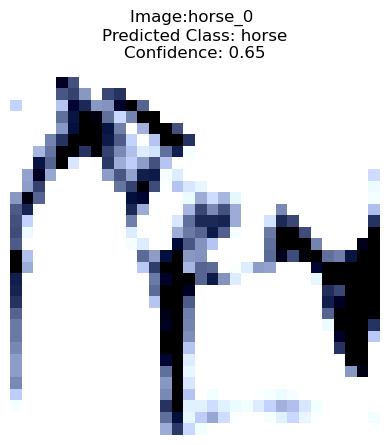

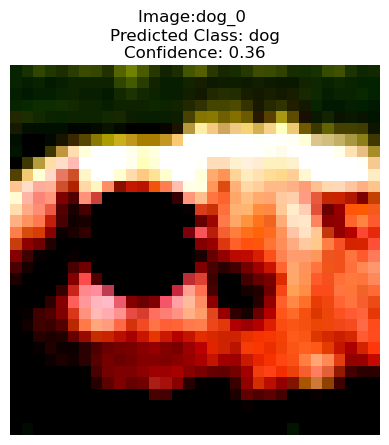

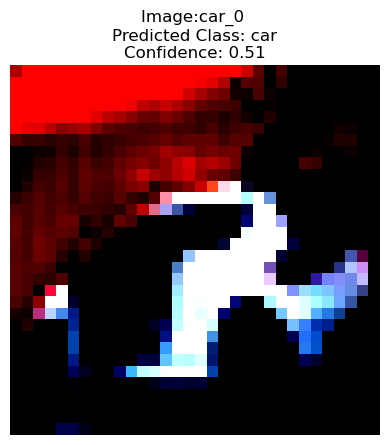

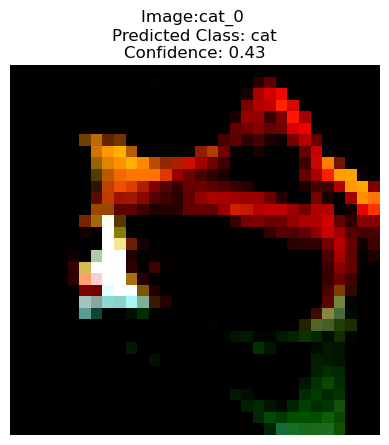

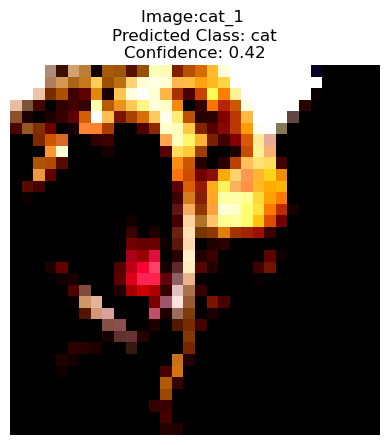

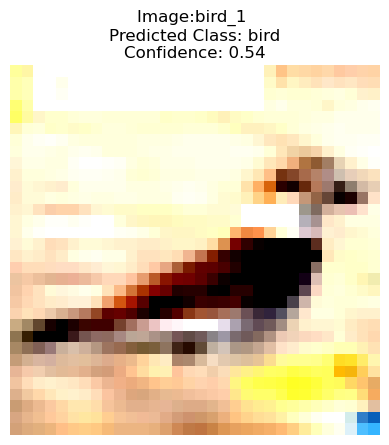

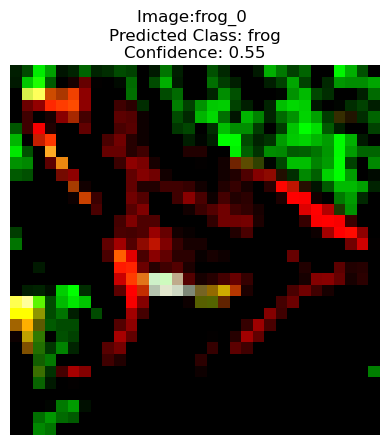

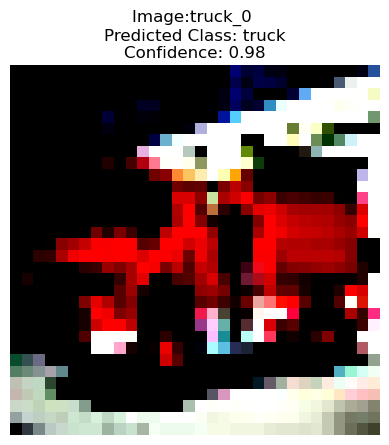

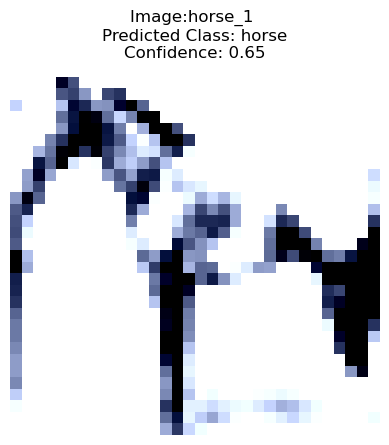

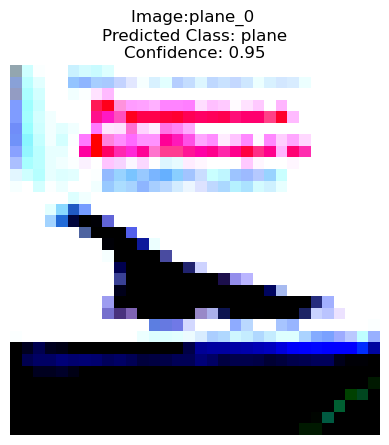

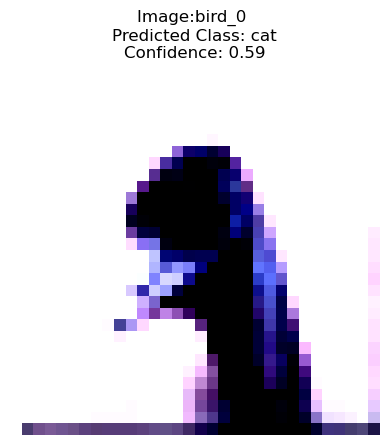

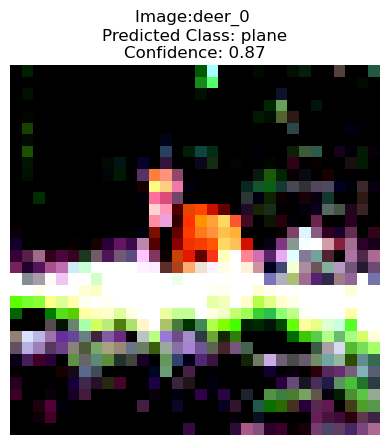

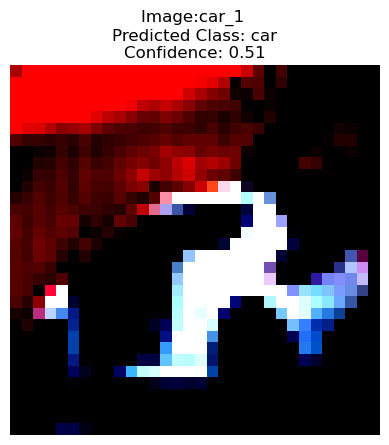

In [253]:
# Directory containing saved images
save_dir = './saved_images'

# List all files in the directory
image_files = [f for f in os.listdir(save_dir) if f.endswith('.png')]

# Iterate over each image file
for image_file in image_files:
    # Construct the full path to the image
    image_path = os.path.join(save_dir, image_file)

    # Perform inference
    predicted_class, confidence = inference(image_path)

    # Display the image along with predictions
    image_name = os.path.splitext(image_file)[0]
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Image:{image_name} \nPredicted Class: {classes[predicted_class]}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()